In [1]:
import os
import sys

sys.path.append(os.path.abspath(os.path.dirname(os.path.dirname(os.path.join(os.getcwd())))))

import json
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

from data_utils.utils import keep_existing_photos, downsample_group
from data_utils.dataset import MultimodalDataset, train_transform, val_transform

from model.fusion_model import FusionModel
from model.utils import (
    get_device,
    train_model_single_epoch_multimodal,
    validate_model_single_epoch_multimodal,
    save_checkpoint,
    evaluate_model_multimodal,
    plot_history,
)

/Users/ericxia/Library/Caches/pypoetry/virtualenvs/food-classification-nES7ttkF-py3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Data preprocessing

In [2]:
base_dir = "../../"

business_df = pd.read_json(f'{base_dir}data/yelp_dataset/yelp_academic_dataset_business.json', lines=True)
photos_df = pd.read_json(f'{base_dir}data/yelp_photos/photos.json', lines=True)
top_reviews_per_restaurant = pd.read_csv(f'{base_dir}data/yelp_dataset/top_reviews_per_restaurant_with_summary.csv')

photo_dir = f"{base_dir}data/yelp_photos/resized_photos"
photos_df = keep_existing_photos(photos_df, photo_dir)

photos_df = photos_df[photos_df['label'] == 'food'].copy()

categories_df = business_df[['business_id', 'attributes']].copy()
photos_df = photos_df.merge(categories_df, on="business_id", how="left")

photos_df = photos_df[photos_df['attributes'].notna()]
photos_df['price_range'] = photos_df['attributes'].apply(lambda x: x.get('RestaurantsPriceRange2'))

photos_df['price_range'] = photos_df['price_range'].astype(int)
photos_df['price_range'] = photos_df['price_range'].replace({2: 1, 3: 2, 4: 2}) 

food_with_reviews_df = photos_df.merge(top_reviews_per_restaurant, on="business_id", how="left")

Checking images: 100%|██████████| 200100/200100 [00:05<00:00, 34591.34it/s]


In [3]:
food_with_reviews_df_unique = food_with_reviews_df.drop_duplicates(subset=["business_id"], keep="first")
food_with_reviews_df_unique.price_range.value_counts()

price_range
1    21395
2     1102
Name: count, dtype: int64

In [4]:
price_2_num = (food_with_reviews_df.price_range == 2).sum()

food_df = food_with_reviews_df.groupby('price_range', group_keys=False).apply(
    lambda x: downsample_group(x, price_2_num) if x.name in [1] else x  # Only downsample for price_range 1 and 2
)

food_df['price_range'] = food_df['price_range'] - 1

/var/folders/6n/sm2tfzkn2hjd8cpfn_256ph00000gp/T/ipykernel_22375/3714349089.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  food_df = food_with_reviews_df.groupby('price_range', group_keys=False).apply(


In [5]:
# unique_ids = food_with_reviews_df.business_id.unique()
# np.random.shuffle(unique_ids)
# total = len(unique_ids)
# train_size = int(0.90 * total)
# val_size = int(0.05 * total)
# test_size = total - train_size - val_size
# train_ids = unique_ids[:train_size]
# val_ids = unique_ids[train_size:train_size + val_size]
# test_ids = unique_ids[train_size + val_size:]

with open(f'{base_dir}data/multimodal_split_ids.json') as f:
    ids_dict = json.load(f)

train_ids = ids_dict['train_ids']
val_ids = ids_dict['val_ids']
test_ids = ids_dict['test_ids']

train_df = food_df[food_df.business_id.isin(train_ids)]
val_df = food_df[food_df.business_id.isin(val_ids)]
test_df = food_df[food_df.business_id.isin(test_ids)]

In [6]:
label = 'price_range'

train_dataset = MultimodalDataset(train_df, photo_dir, label)
val_dataset = MultimodalDataset(val_df, photo_dir, label)
test_dataset = MultimodalDataset(test_df, photo_dir, label)

train_dataset.transform = train_transform
val_dataset.transform = val_transform
test_dataset.transform = val_transform

batch_size = 64

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
)

for batch in train_loader:
    print("Images shape:", batch['image'].shape)  
    print("Input_ids shape:", batch['input_ids'].shape)
    print("Labels shape:", batch['label'].shape)
    break

Images shape: torch.Size([64, 3, 224, 224])
Input_ids shape: torch.Size([64, 128])
Labels shape: torch.Size([64])


### Model training

In [7]:
num_classes = 2
device = get_device()

model = FusionModel()
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-3)
scaler = torch.amp.GradScaler("cuda")
grad_clip = 1
ckpt_dir = "checkpoints/price_model_multimodal_binary_unique_restaurants_duplicate_photos"

history = {
    "train_loss": [],
    "train_accuracy": [],
    "val_loss": [],
    "val_accuracy": []
}

# Training loop
def train_model(model, train_loader, val_loader, criterion, optimizer, device, scaler, grad_clip, history, ckpt_dir, num_epochs=10):
    model.train()

    for epoch in range(1, num_epochs+1):
        train_loss, train_accuracy = train_model_single_epoch_multimodal(
            model, train_loader, criterion, optimizer, device, scaler, grad_clip
        )
        val_loss, val_accuracy = validate_model_single_epoch_multimodal(model, val_loader, criterion, device)

        print(
            f"[Epoch {epoch}/{num_epochs}]",
            f"Train Loss: {train_loss:.4f} | " f"Train Accuracy: {train_accuracy:.4f}",
            f"Val Loss: {val_loss:.4f} | " f"Val Accuracy: {val_accuracy:.4f}"
        )

        history["train_loss"].append(train_loss)
        history["train_accuracy"].append(train_accuracy)
        history["val_loss"].append(val_loss)
        history["val_accuracy"].append(val_accuracy)

        save_checkpoint(epoch, model, optimizer, history, ckpt_dir)

/Users/ericxia/Library/Caches/pypoetry/virtualenvs/food-classification-nES7ttkF-py3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/ericxia/Library/Caches/pypoetry/virtualenvs/food-classification-nES7ttkF-py3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/Users/ericxia/Library/Caches/pypoetry/virtualenvs/food-classification-nES7ttkF-py3.10/lib/python3.10/site-packages/torch/amp/grad_scaler.py:132: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  

In [123]:
num_epochs = 20
train_model(model, train_loader, val_loader, criterion, optimizer, device, scaler, grad_clip, history, ckpt_dir, num_epochs=num_epochs)

Training: 100%|██████████| 228/228 [02:57<00:00,  1.28it/s, loss=0.569]


[Epoch 1/20] Train Loss: 0.5879 | Train Accuracy: 0.6812 Val Loss: 0.4807 | Val Accuracy: 0.7484
Model checkpoint saved at checkpoints/price_model_multimodal_binary_unique_restaurants_duplicate_photos/ckpt_1


Training: 100%|██████████| 228/228 [02:56<00:00,  1.29it/s, loss=0.516]


[Epoch 2/20] Train Loss: 0.5313 | Train Accuracy: 0.7394 Val Loss: 0.4773 | Val Accuracy: 0.7654
Model checkpoint saved at checkpoints/price_model_multimodal_binary_unique_restaurants_duplicate_photos/ckpt_2


Training: 100%|██████████| 228/228 [02:53<00:00,  1.31it/s, loss=0.473]


[Epoch 3/20] Train Loss: 0.5083 | Train Accuracy: 0.7513 Val Loss: 0.4865 | Val Accuracy: 0.7444
Model checkpoint saved at checkpoints/price_model_multimodal_binary_unique_restaurants_duplicate_photos/ckpt_3


Training: 100%|██████████| 228/228 [02:54<00:00,  1.31it/s, loss=0.534]


[Epoch 4/20] Train Loss: 0.5147 | Train Accuracy: 0.7528 Val Loss: 0.4862 | Val Accuracy: 0.7759
Model checkpoint saved at checkpoints/price_model_multimodal_binary_unique_restaurants_duplicate_photos/ckpt_4


Training: 100%|██████████| 228/228 [02:54<00:00,  1.31it/s, loss=0.441]


[Epoch 5/20] Train Loss: 0.5017 | Train Accuracy: 0.7570 Val Loss: 0.4590 | Val Accuracy: 0.7837
Model checkpoint saved at checkpoints/price_model_multimodal_binary_unique_restaurants_duplicate_photos/ckpt_5


Training: 100%|██████████| 228/228 [02:52<00:00,  1.32it/s, loss=0.417]


[Epoch 6/20] Train Loss: 0.4978 | Train Accuracy: 0.7577 Val Loss: 0.4841 | Val Accuracy: 0.7772
Model checkpoint saved at checkpoints/price_model_multimodal_binary_unique_restaurants_duplicate_photos/ckpt_6


Training: 100%|██████████| 228/228 [02:51<00:00,  1.33it/s, loss=0.509]


[Epoch 7/20] Train Loss: 0.4918 | Train Accuracy: 0.7614 Val Loss: 0.4760 | Val Accuracy: 0.7851
Model checkpoint saved at checkpoints/price_model_multimodal_binary_unique_restaurants_duplicate_photos/ckpt_7


Training: 100%|██████████| 228/228 [02:54<00:00,  1.30it/s, loss=0.386]


[Epoch 8/20] Train Loss: 0.4897 | Train Accuracy: 0.7595 Val Loss: 0.4533 | Val Accuracy: 0.7772
Model checkpoint saved at checkpoints/price_model_multimodal_binary_unique_restaurants_duplicate_photos/ckpt_8


Training: 100%|██████████| 228/228 [02:52<00:00,  1.32it/s, loss=0.377]


[Epoch 9/20] Train Loss: 0.4806 | Train Accuracy: 0.7717 Val Loss: 0.5120 | Val Accuracy: 0.7693
Model checkpoint saved at checkpoints/price_model_multimodal_binary_unique_restaurants_duplicate_photos/ckpt_9


Training: 100%|██████████| 228/228 [02:57<00:00,  1.29it/s, loss=0.504]


[Epoch 10/20] Train Loss: 0.4739 | Train Accuracy: 0.7719 Val Loss: 0.4591 | Val Accuracy: 0.7798
Model checkpoint saved at checkpoints/price_model_multimodal_binary_unique_restaurants_duplicate_photos/ckpt_10


Training: 100%|██████████| 228/228 [02:53<00:00,  1.32it/s, loss=0.617]


[Epoch 11/20] Train Loss: 0.4871 | Train Accuracy: 0.7641 Val Loss: 0.4519 | Val Accuracy: 0.7746
Model checkpoint saved at checkpoints/price_model_multimodal_binary_unique_restaurants_duplicate_photos/ckpt_11


Training: 100%|██████████| 228/228 [02:54<00:00,  1.31it/s, loss=0.389]


[Epoch 12/20] Train Loss: 0.4777 | Train Accuracy: 0.7699 Val Loss: 0.4740 | Val Accuracy: 0.7772
Model checkpoint saved at checkpoints/price_model_multimodal_binary_unique_restaurants_duplicate_photos/ckpt_12


Training: 100%|██████████| 228/228 [03:34<00:00,  1.06it/s, loss=0.397]


[Epoch 13/20] Train Loss: 0.4756 | Train Accuracy: 0.7722 Val Loss: 0.4742 | Val Accuracy: 0.7798
Model checkpoint saved at checkpoints/price_model_multimodal_binary_unique_restaurants_duplicate_photos/ckpt_13


Training: 100%|██████████| 228/228 [07:06<00:00,  1.87s/it, loss=0.423]


[Epoch 14/20] Train Loss: 0.4810 | Train Accuracy: 0.7668 Val Loss: 0.4506 | Val Accuracy: 0.7746
Model checkpoint saved at checkpoints/price_model_multimodal_binary_unique_restaurants_duplicate_photos/ckpt_14


Training: 100%|██████████| 228/228 [06:53<00:00,  1.81s/it, loss=0.397]


[Epoch 15/20] Train Loss: 0.4693 | Train Accuracy: 0.7757 Val Loss: 0.4486 | Val Accuracy: 0.7864
Model checkpoint saved at checkpoints/price_model_multimodal_binary_unique_restaurants_duplicate_photos/ckpt_15


Training: 100%|██████████| 228/228 [07:03<00:00,  1.86s/it, loss=0.544]


[Epoch 16/20] Train Loss: 0.4652 | Train Accuracy: 0.7769 Val Loss: 0.4620 | Val Accuracy: 0.7746
Model checkpoint saved at checkpoints/price_model_multimodal_binary_unique_restaurants_duplicate_photos/ckpt_16


Training: 100%|██████████| 228/228 [06:59<00:00,  1.84s/it, loss=0.452]


[Epoch 17/20] Train Loss: 0.4621 | Train Accuracy: 0.7833 Val Loss: 0.4615 | Val Accuracy: 0.7851
Model checkpoint saved at checkpoints/price_model_multimodal_binary_unique_restaurants_duplicate_photos/ckpt_17


Training: 100%|██████████| 228/228 [06:00<00:00,  1.58s/it, loss=0.563]


[Epoch 18/20] Train Loss: 0.4592 | Train Accuracy: 0.7801 Val Loss: 0.4469 | Val Accuracy: 0.7877
Model checkpoint saved at checkpoints/price_model_multimodal_binary_unique_restaurants_duplicate_photos/ckpt_18


Training: 100%|██████████| 228/228 [03:28<00:00,  1.09it/s, loss=0.531]


[Epoch 19/20] Train Loss: 0.4542 | Train Accuracy: 0.7859 Val Loss: 0.4820 | Val Accuracy: 0.7641
Model checkpoint saved at checkpoints/price_model_multimodal_binary_unique_restaurants_duplicate_photos/ckpt_19


Training: 100%|██████████| 228/228 [03:54<00:00,  1.03s/it, loss=0.354]


[Epoch 20/20] Train Loss: 0.4569 | Train Accuracy: 0.7835 Val Loss: 0.4506 | Val Accuracy: 0.7811
Model checkpoint saved at checkpoints/price_model_multimodal_binary_unique_restaurants_duplicate_photos/ckpt_20


### Model evaluation

In [8]:
ckpt = torch.load(f"{base_dir}saved_models/price_binary_multimodal/ckpt_best", map_location="cpu")
model = FusionModel()
model.load_state_dict(ckpt['model_state_dict'])
model.to(device)
model.eval()

FusionModel(
  (image_encoder): ResNetFeatureExtractor(
    (feature_extractor): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
       

In [9]:
evaluate_model_multimodal(model, train_loader, device, ['0', '1'])

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.84      0.82      7249
           1       0.84      0.79      0.81      7326

    accuracy                           0.82     14575
   macro avg       0.82      0.82      0.82     14575
weighted avg       0.82      0.82      0.82     14575



In [10]:
evaluate_model_multimodal(model, test_loader, device, ['0', '1'])

Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.81      0.80       462
           1       0.78      0.76      0.77       414

    accuracy                           0.78       876
   macro avg       0.78      0.78      0.78       876
weighted avg       0.78      0.78      0.78       876



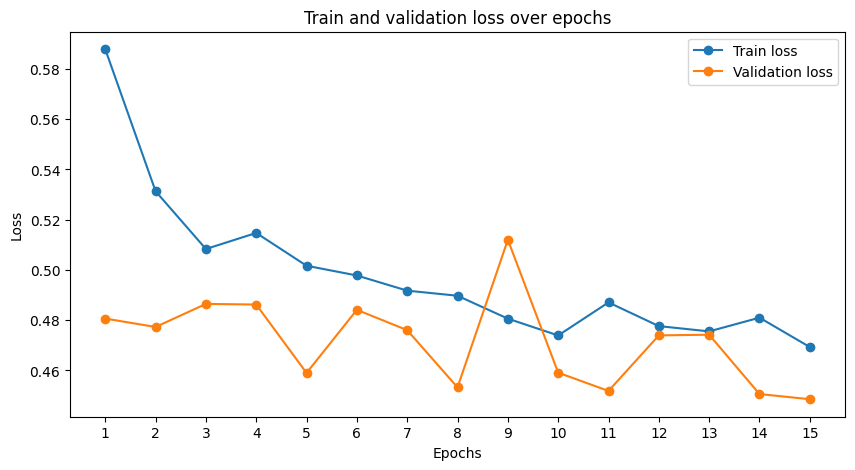

In [10]:
history = ckpt['history']
plot_history(history, metric='loss')

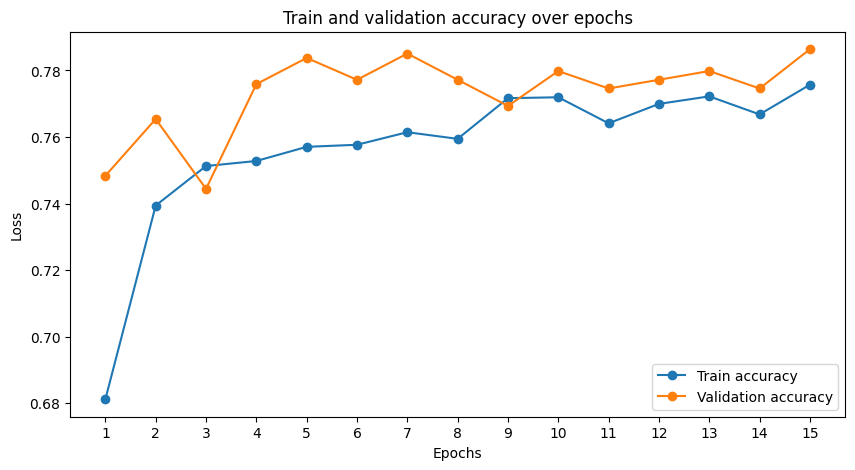

In [11]:
plot_history(history, metric='accuracy')